# Capsule Network implementation
This implementation is largely based upon the [Aurélien's implementation](https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb). Some improvements are made as mentioned in the [README.md](https://github.com/layog/capsnets-tensorflow/blob/master/README.md)

Importing the required libraries

In [1]:
# For compatibility in Python 2 and 3
from __future__ import print_function, division, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Required code libraries
import tensorflow as tf
import numpy as np
import tensorflow

## Reproducability

In [2]:
# In case the notebook is ran again, without restarting the kernel
tf.reset_default_graph()

# For now, same result always
np.random.seed(10)
tf.set_random_seed(10)

## Loading MNIST

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
!mkdir -p "/tmp/data"
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


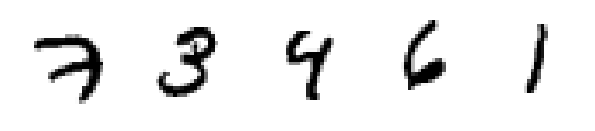

In [4]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [5]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

## Implementation

### Input Images

In [6]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

### Primary Capsules

Defining the configuration for the primary capsules

In [7]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6
# The 6 * 6 is the size of each kernel after the convolution
# For more information, check the Aurelien's notebook
caps1_n_dims = 8

# Primary capsules will be composed of two convolution layers
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims,
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

Note that the number of filters in the last convolution layers have to be caps1_n_maps * caps1_n_dims

Create the convolution layers

In [8]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

Reshape the output of convolution layers to represent in the format of (batch_size, no_of_capsules, each_capsule_dimension)

In [9]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

Defining the safe squash, for more information refer to the Aurelien's Implementation

In [10]:
def safe_squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="safe_squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [11]:
caps1_output = safe_squash(caps1_raw)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
# Check the output shape, to make sure everything is correct. The expected shape is (batch_size, no_caps, dim_caps)
caps1_output

<tf.Tensor 'safe_squash/mul:0' shape=(?, 1152, 8) dtype=float32>

### Digit Capsules

Setting dimensions for the digit capsules

In [13]:
caps2_n_caps = 10
caps2_n_dims = 16

Let's create the weights mapping primary capsules to the digit capsules

In [14]:
init_sigma = 0.01

W_init = tf.random_normal(
    shape=(caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

Let's use [`tf.einsum`](https://www.tensorflow.org/api_docs/python/tf/einsum) for multiplying caps1_output and W. This part differs from the Aurelien's notebook. He used `expand_dims` and `tile` functions to match the shape for both the tensors.

In [15]:
caps2_predicted = tf.einsum('ijk,jlmk->ijlm', caps1_output, W, name="caps2_predicted")

In [16]:
# Check the output shape. Expected (batch_size, n_caps1, n_caps2, dim_caps2)
caps2_predicted

<tf.Tensor 'caps2_predicted/transpose_2:0' shape=(?, 1152, 10, 16) dtype=float32>

### Routing by Agreement

First, let's define the routing parameters

In [17]:
with tf.name_scope("dynamic_routing_params"):
    batch_size = tf.shape(X)[0]
    
    # Setting the number of routing loops
    routing_loops = tf.placeholder_with_default(2, shape=(), name="routing_loops")
    
    # Initializing routing weights, agreement, counter and output
    raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps],
                           dtype=tf.float32, name="raw_weights")
    agreement = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps],
                         dtype=tf.float32, name="raw_weights")
    caps2_dummy_output = tf.zeros([batch_size, caps2_n_caps, caps2_n_dims],
                                  dtype=tf.float32, name="caps2_dummy_output")
    counter = tf.constant(0)

Setup for the loop with condition and the actual algorithm

In [18]:
def routing_condition(a, b, c, counter):
    return tf.less(counter, routing_loops)

def routing_algorithm(caps2_intermediate_output, raw_weights, agreement, counter):
    # Converting raw weights to routing weights using agreement
    raw_weights = tf.add(raw_weights, agreement)
    routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")
    
    # Getting the final predictions
    weighted_predictions = tf.einsum('ijk,ijkl->ijkl', routing_weights,
                                     caps2_predicted, name="weighted_predictions")
    weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=False,
                                 name="weighted_sum")
    caps2_output = safe_squash(weighted_sum, name="caps2_output")
    
    # Recalculating agreement
    agreement = tf.einsum('ijkl,ikl->ijk', caps2_predicted, caps2_output,
                          name="agreement")
    
    return caps2_output, raw_weights, agreement, tf.add(counter, 1)

Let's loop over it

In [19]:
caps2_output, _, _, counter = tf.while_loop(routing_condition, routing_algorithm,
                                            [caps2_dummy_output, raw_weights, agreement, counter])

Instructions for updating:
dim is deprecated, use axis instead


Defining safe norm for the same reason as safe squash

In [20]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [21]:
y_proba = safe_norm(caps2_output, axis=-1, name="y_proba")

To predict the class of each instance, we can just select the one with the highest estimated probability. To do this, let's start by finding its index using `tf.argmax()`:

In [22]:
y_pred = tf.argmax(y_proba, axis=1, name="y_proba")

In [23]:
# Let's check the output shape
y_pred

<tf.Tensor 'y_proba_1:0' shape=(?,) dtype=int64>

### Labels

We will need a placeholder for the labels:

In [24]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

### Margin Loss

The paper uses a special margin loss to make it possible to detect two or more different digits in each image:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

* $T_k$ is equal to 1 if the digit of class $k$ is present, or 0 otherwise.
* In the paper, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$.
* Note that there was an error in the video (at 15:47): the max operations are squared, not the norms. Sorry about that.

In [25]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

Since `y` will contain the digit classes, from 0 to 9, to get $T_k$ for every instance and every class, we can just use the `tf.one_hot()` function:

In [26]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [27]:
# Checking shape
T, caps2_output

(<tf.Tensor 'T:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'while/Exit:0' shape=(?, 10, 16) dtype=float32>)

Take the norm of the 16D vector

In [28]:
caps2_output_norm = safe_norm(caps2_output, axis=-1, keep_dims=False,
                              name="caps2_output_norm")

Let's calculate the present error

In [29]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

and the absent error

In [30]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

Loss for each batch

In [31]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

Net Loss

In [32]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# Shape checking
margin_loss

<tf.Tensor 'margin_loss:0' shape=() dtype=float32>

### Reconstruction
Used as a regularizer (and also helps a lot in visualization)

#### Mask
The use of mask can be read from Aurelien's implementation or from the [original paper](https://arxiv.org/abs/1710.09829). I've copied the following from the other notebook

The paper mentions that during training, instead of sending all the outputs of the capsule network to the decoder network, we must send only the output vector of the capsule that corresponds to the target digit. All the other output vectors must be masked out. At inference time, we must mask all output vectors except for the longest one, i.e., the one that corresponds to the predicted digit. You can see this in the paper's figure 2 (at 18:15 in the video): all output vectors are masked out, except for the reconstruction target's output vector.

In [33]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

Now let's use `tf.cond()` to define the reconstruction targets as the labels `y` if `mask_with_labels` is `True`, or `y_pred` otherwise.

In [34]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

An important point here  
we will **always need to feed a value for the y placeholder** (even if mask_with_layers is False). This is a bit annoying, but we can pass an empty array, because TensorFlow won't use it anyway (it just does not know it yet when it checks for dependencies).

In [35]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

Let's reshape the reconstruction mask to match caps2_output. But, first let's check their shape

In [36]:
reconstruction_mask, caps2_output

(<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'while/Exit:0' shape=(?, 10, 16) dtype=float32>)

In [37]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, caps2_n_caps, 1],
    name="reconstruction_mask_reshaped")

Mask the output

In [38]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

One last reshape operation to flatten the decoder's inputs:

In [39]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

This gives us an array of shape (_batch size_, 160):

In [40]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

### Decoder

Now let's build the decoder. It's quite simple: two dense (fully connected) ReLU layers followed by a dense output sigmoid layer:

In [41]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [42]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

### Reconstruction Loss

Now let's compute the reconstruction loss. It is just the squared difference between the input image and the reconstructed image:

In [43]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_sum(squared_difference,
                                    name="reconstruction_loss")

### Final Loss

The final loss is the sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training):

In [44]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

### Final customary parameters

#### Accuracy

In [45]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

#### Training Operation

In [46]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

#### Init and Saver

In [47]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And we are done constructing the architecture

### Training

In [50]:
n_epochs = 2
batch_size = 64
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           routing_loops: 3,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               routing_loops: 3,
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Epoch: 1  Val accuracy: 99.2788%  Loss: 0.244186 (improved)
Epoch: 2  Val accuracy: 99.2989%  Loss: 0.229551 (improved)


### Evaluation

In [51]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           routing_loops: 3,
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.3189%  Loss: 0.229695   


First I ran the training for 5 epochs with 2 routing loops which gave me a test accuracy of 99.2188%

Then, I ran the training for 2 more epochs with 3 routing loops, which took me to a test accuracy of 99.3189%

## Experimentation with Capsules

Let's first define the helper plotting functions

In [52]:
def multiple_plots(input_images, input_labels, no_of_images):
    plt.figure(figsize=(2 * no_of_images, 1))
    for i in range(no_of_images):
        plt.subplot(1, no_of_images, i + 1)
        plt.imshow(np.reshape(input_images[i], [28, 28]), cmap="binary")
        plt.title("Label: {}".format(input_labels[i]))
        plt.axis("off")
    plt.show()
    
def side_by_side_plot(input_images, input_labels, predicted_images, predicted_labels, no_of_images):
    multiple_plots(input_images, input_labels, no_of_images)
    multiple_plots(predicted_images, predicted_labels, no_of_images)

Also, let's keep a little helper function for getting the predictions

In [53]:
def get_predictions(input_images, input_labels):
    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)

        caps_output, decoded_images, predicted_values = sess.run([caps2_output, decoder_output, y_pred],
                                                                  feed_dict={
                                                                      X: input_images,
                                                                      mask_with_labels: True,
                                                                      y: input_labels
                                                                  })
    return caps_output, decoded_images, predicted_values

Choosing a single image to perform tests on

INFO:tensorflow:Restoring parameters from ./my_capsule_network


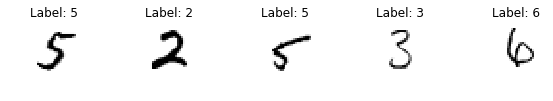

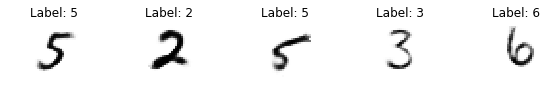

In [54]:
no_of_images = 5
test_images, test_labels = mnist.test.images[:no_of_images], mnist.test.labels[:no_of_images]
test_images = np.reshape(test_images, [-1, 28, 28, 1])
_, decoded_images, predicted_values = get_predictions(test_images, test_labels)
side_by_side_plot(test_images, test_labels, decoded_images, predicted_values, no_of_images)

2 looks good for experimentation. Let's pick that 

In [60]:
test_image, test_label = test_images[1], test_labels[1]

Let the experimentation begin

#### Modifying input image

Let's first implement multiple modifications to the input image and then test the output of the decoder network and the how the capsule outputs vary

In [61]:
# Helpers for image modifications
import skimage
from skimage import transform
from skimage import filters

def transformation_bases(input_image, min_transform, max_transform, steps=10, transform_name="rotation"):
    transformation_values = np.linspace(min_transform, max_transform, steps)
    transformations = map(lambda x: transform.AffineTransform(**({transform_name: x})), transformation_values)
    output_images = map(lambda trans: transform.warp(input_image, inverse_map=trans),
                        transformations)
    return np.asarray(output_images)

def get_multiple_shears(input_image, min_shear, max_shear, steps=10):
    return transformation_bases(input_image, min_shear, max_shear, steps, "shear")

def get_multiple_rotations(input_image, min_shear, max_shear, steps=10):
    return transformation_bases(input_image, min_shear, max_shear, steps, "rotation")

def get_blurred_images(input_image, min_sigma, max_sigma, steps=10):
    sigmas = np.linspace(min_sigma, max_sigma, steps)
    output_images = map(lambda x: filters.gaussian(input_image, x), sigmas)
    return np.asarray(output_images)

In [62]:
# Setting the no. of transformations
no_transforms = 6

###### Rotating image

INFO:tensorflow:Restoring parameters from ./my_capsule_network


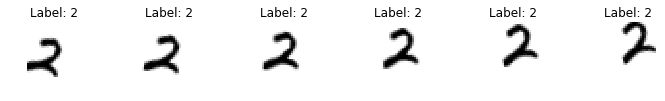

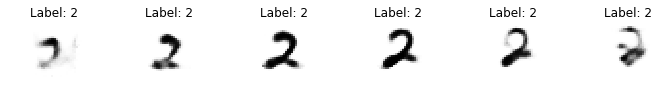

In [65]:
transformed_images = get_multiple_rotations(test_image, -0.3, 0.3, no_transforms)
capsule_outputs, predicted_images, predicted_labels = get_predictions(transformed_images, [test_label] * no_transforms)
side_by_side_plot(transformed_images, [test_label] * no_transforms, predicted_images, predicted_labels, no_transforms)

###### Shearing image

INFO:tensorflow:Restoring parameters from ./my_capsule_network


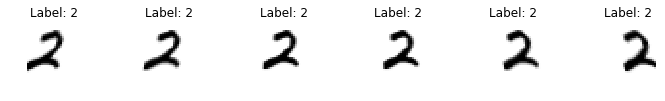

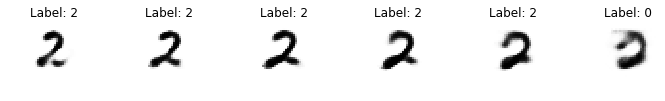

In [66]:
transformed_images = get_multiple_shears(test_image, -0.3, 0.3, no_transforms)
capsule_outputs, predicted_images, predicted_labels = get_predictions(transformed_images, [test_label] * no_transforms)
side_by_side_plot(transformed_images, [test_label] * no_transforms, predicted_images, predicted_labels, no_transforms)

###### Blurring image

INFO:tensorflow:Restoring parameters from ./my_capsule_network


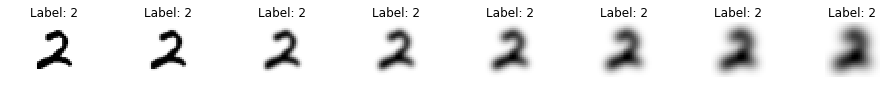

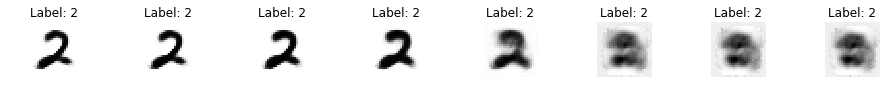

In [67]:
# Let's get some more blurred images
no_transforms = 8

transformed_images = get_blurred_images(test_image, 0, 3, no_transforms)
capsule_outputs, predicted_images, predicted_labels = get_predictions(transformed_images, [test_label] * no_transforms)
side_by_side_plot(transformed_images, [test_label] * no_transforms, predicted_images, predicted_labels, no_transforms)

The network tries to replicate the image that it sees (Well that is exactly why decoder is used) but it also maintains more sharpness (in case of blurring) in the image than the input image, upto the point where it can understand what the image is about. So, it seems like capsules are trying to nulify the effect of the blurring but in case of rotation and shearing, capsules are mainly trying to modify themselves as well accordingly

But the main point is to check how the capsule output differs. Let's check that for the blurred images capsule outputs.  
Here I'll only check how the norm of each vector differs but many other insights can be obtained by looking at how the vector changes direction and yet maintaining the same norm.

In [68]:
# Helper function to calculate the vector
def get_norm(capsule_outputs):
    return np.linalg.norm(capsule_outputs, axis=-1)

def get_mean_variance(normalized_outputs):
    return np.mean(normalized_outputs, axis=0), np.std(normalized_outputs, axis=0)

In [69]:
normalized_outputs = get_norm(capsule_outputs)
get_mean_variance(normalized_outputs)

(array([0.0391247 , 0.02081201, 0.44920984, 0.03073409, 0.03162286,
        0.03892412, 0.03145587, 0.04395023, 0.0264328 , 0.02273624],
       dtype=float32),
 array([0.03645606, 0.01834982, 0.38846776, 0.02746612, 0.03093059,
        0.04217108, 0.02643935, 0.04270701, 0.02412685, 0.02176611],
       dtype=float32))

The vector at index 2 varies largely and also have higher norm than the rest of the images, clearly indicating that the prediction is definitely 2 and the modification is also being made w.r.t. that vector

#### Modifying the capsule outputs

Let's first get the un-altered capsule outputs

In [70]:
capsule_outputs, _, _ = get_predictions(test_image.reshape([1, 28, 28, 1]), [test_label])

INFO:tensorflow:Restoring parameters from ./my_capsule_network


Define a helper function for tweaking the pose parameters

In [71]:
def tweak_pose_params(single_caps_output, index_to_tweak=0, min_tweaking=-0.5, max_tweaking=0.5, steps=10):
    tweak_params = np.linspace(min_tweaking, max_tweaking, steps)
    updated_capsules = np.reshape(single_caps_output, (1,) + single_caps_output.shape)
    updated_capsules = np.tile(updated_capsules, [steps, 1, 1])
    tweaks = np.zeros((steps,) + single_caps_output.shape)
    for tweak_index in range(steps):
        tweaks[tweak_index, :, index_to_tweak] = tweak_params[tweak_index]
    return tweaks + updated_capsules

Let's plot the tweaking for the first 4 indices in vectors

INFO:tensorflow:Restoring parameters from ./my_capsule_network


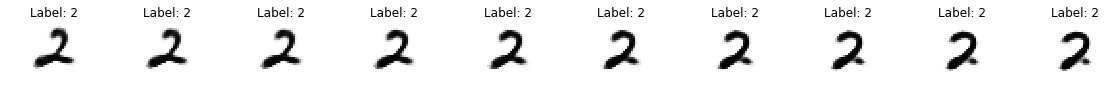

INFO:tensorflow:Restoring parameters from ./my_capsule_network


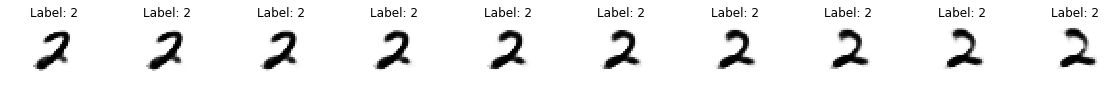

INFO:tensorflow:Restoring parameters from ./my_capsule_network


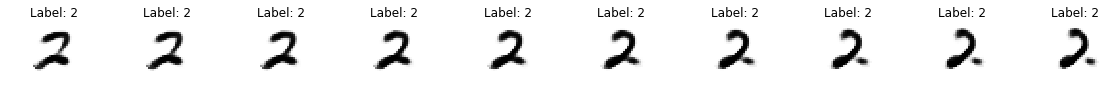

INFO:tensorflow:Restoring parameters from ./my_capsule_network


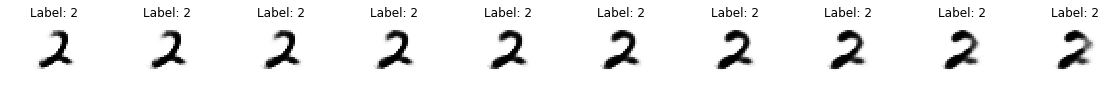

In [72]:
for index in range(4):
    tweaked_capsule_outputs = tweak_pose_params(capsule_outputs[0], index_to_tweak=index)
    
    # Getting the predictions
    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)
        decoded_images, predicted_values = sess.run([decoder_output, y_pred],
                                                    feed_dict={
                                                        caps2_output: tweaked_capsule_outputs,
                                                        mask_with_labels: True,
                                                        y: [test_label]*10
                                                    })
    
    multiple_plots(decoded_images, predicted_values, 10)

So, each dimension of a vector has learned something. Like the first dimension is trying to establish how large is the curve of the "2" and how dark is the base line in the number